In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import random
from bs4 import BeautifulSoup

In [2]:
#抓台灣中型一百的股票代號
stocks = []
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36",
    "scheme" : 'https',
    "path" : '/tw/image/Goodinfo.ico', 
    "Referer" : 'https://goodinfo.tw/tw/StockDetail.asp?STOCK_ID=0051',
    "Cookie" : 'CLIENT%5FID=20230920214311062%5F140%2E117%2E80%2E123; IS_TOUCH_DEVICE=F; SCREEN_SIZE=WIDTH=1920&HEIGHT=1080; TW_STOCK_BROWSE_LIST=0051'
}
response = requests.get("https://goodinfo.tw/tw/StockDetail.asp?STOCK_ID=0051", headers=headers)
response.encoding = "utf-8"
soup = BeautifulSoup(response.text, "html.parser")
stock_tags = soup.select('a[class="link_black"][target="_self"]')
for tag in stock_tags:
    soup = BeautifulSoup(str(tag), "html.parser")
    stock = soup.select('a.link_black nobr')
    stocks.append(stock[0].text)


In [3]:
#用股票代號去爬證交所的股價並存入DataFrame

start_date = '2022-09-15'
end_date = '2023-09-15'
#生成月份區間
date_range = pd.date_range(start=start_date, end=end_date, freq='M')
yyyymm = date_range.strftime('%Y%m').tolist()

stocks_prices = {}
for stock in stocks:
    df = pd.DataFrame(columns=['Date', 'Closing Price'])
    dates = []
    closing_price = []
    for date in yyyymm:
        url = f'https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date={date}&stockNo={stock}'
        response = requests.get(url)
        data = response.json()
        if 'data' in data:
            stock_data = data['data']
            for idx, row in enumerate(stock_data):
                dates.append(row[0])
                if row[6] == '--':
                    closing_price.append(stock_data[idx-1][6])
                else:
                    closing_price.append(row[6])
        else:
            print(f'{stock} 之 {date} 價格爬取失敗')
    df['Date'] = dates
    df['Closing Price'] = closing_price
    stocks_prices[stock] = df

In [4]:
def get_stocks_returns(stocks_prices):
    stocks_daily_returns = {}
    for stock in stocks_prices:
        stock_daily_price = np.array(stocks_prices[stock]['Closing Price'].str.replace(',', '')).astype(float)
        stocks_daily_returns[stock] = np.diff(stock_daily_price) / stock_daily_price[:-1]
    return stocks_daily_returns

In [5]:
stocks_returns = get_stocks_returns(stocks_prices)

In [6]:
# #隨機生成波動率介於0.02~0.15的100組（股票）的收益率
# def random_returns():
#     days = 252
#     samples = 100
#     volatility = np.linspace(0.02, 0.15, 20)    # 每日收益率的標準差（波動率）

#     random_returns = []
#     for i in range(samples):
#         stock_return = np.random.normal(0, random.choice(volatility), days)
#         random_returns.append(stock_return)

#     return np.array(random_returns)

In [7]:
from collections import Counter

#將收益率陣列長度不等於最長天數的股票刪除
def returns_length_reshape(stocks_returns):
    length = []
    for stock in stocks_returns:
        length.append(len(stocks_returns[stock]))
    max_length = Counter(length).most_common(1)[0][0]
    to_del = []
    for stock in stocks_returns:
        if len(stocks_returns[stock]) != max_length:
            print(f'{stock} 的收益率陣列長度只有 {len(stocks_returns[stock])} 天，不等於最長天數 {max_length}')
            to_del.append(stock)

    #刪除收益率陣列長度不等於最長天數的股票
    for stock in to_del:
        del stocks_returns[stock]

def standard_deviation_matrix(stocks_returns):
    returns = dict(stocks_returns)
    returns_length_reshape(returns)

    stocks_std = []
    for stock in returns:
        stocks_std.append(np.std(returns[stock]))
    return np.diag(stocks_std)

def correlation_matrix(stocks_returns):
    temp_dict = dict(stocks_returns)
    returns_length_reshape(temp_dict)        

    #計算相關係數矩陣
    size = len(temp_dict)
    correlation_matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(i+1, size):
            correlation = np.corrcoef(temp_dict[list(temp_dict.keys())[i]], temp_dict[list(temp_dict.keys())[j]])[0][1]
            correlation_matrix[i][j] = correlation
            correlation_matrix[j][i] = correlation
    np.fill_diagonal(correlation_matrix, 1)
    return correlation_matrix

def V_matrix(stocks_returns):
    V = np.dot(np.dot(standard_deviation_matrix(stocks_returns), correlation_matrix(stocks_returns)), standard_deviation_matrix(stocks_returns))
    return V

In [8]:
v = V_matrix(stocks_returns)

9945 的收益率陣列長度只有 107 天，不等於最長天數 167
9945 的收益率陣列長度只有 107 天，不等於最長天數 167
9945 的收益率陣列長度只有 107 天，不等於最長天數 167


In [9]:
# #隨機生成V
# def random_V(size):
#     matrix_size = size
#     symmetric_matrix = np.zeros((matrix_size, matrix_size))

#     for i in range(matrix_size):
#         for j in range(i + 1, matrix_size):
#             value = np.random.uniform(-1, 1)
#             symmetric_matrix[i, j] = value
#             symmetric_matrix[j, i] = -value  

#     np.fill_diagonal(symmetric_matrix, 1)

#     return symmetric_matrix

In [10]:
# #隨機生成f
# def random_f(size):
#     f = np.random.rand(size)
#     return f

In [11]:
def get_variance_of_protfolio(V, N):
    avg_of_stocks_variance = np.sum([V[i, i] for i in range(min(V.shape))]) / N
    avg_of_stocks_covariance = np.sum([V[i, j] for i in range(min(V.shape)) for j in range(min(V.shape)) if i != j]) / (N * (N - 1) / 2)
    
    variance_of_protfolio = 1 / N * avg_of_stocks_variance + (N - 1) / N * avg_of_stocks_covariance
    sd = np.sqrt(variance_of_protfolio)

    return sd

In [12]:
sd = []
components = []
for i in range(2, 101):
    sd.append(get_variance_of_protfolio(v, i))
    components.append(i)

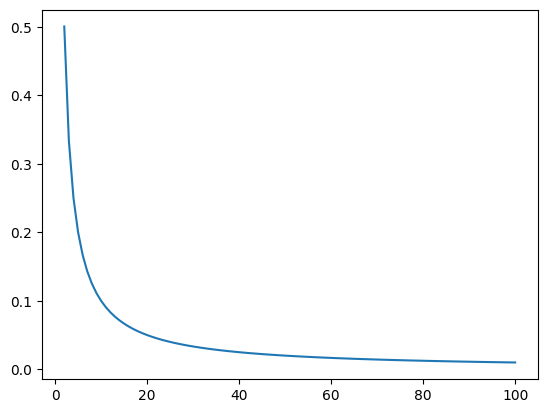

In [13]:
plt.plot(components, sd)